# Clasificación de Tweets de desastres naturales

## Enunciado

En esta competición, se plantea la construcción de un modelo de aprendizaje automático que realice predicciones sobre qué Tweets tratan de desastres reales y cuáles no.

https://www.kaggle.com/vstepanenko/disaster-tweets

## 0. Imports

In [20]:
!nltk.download('stopwords')

zsh:1: unknown sort specifier


In [34]:
# <-- system -->
import os
import string
import re
from html.parser import HTMLParser

# <-- analytics -->
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd

# <-- machine learning -->
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# <-- deep learning -->
from keras import models, layers
# <-- NLP -->
from nltk.corpus import stopwords

## 1. Lectura del conjunto de datos

In [22]:
X_train = pd.read_csv('archive/train.csv')
X_test = pd.read_csv('archive/test.csv')

X_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [23]:
X_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## 2. Visualización del conjunto de datos

In [24]:
print("Tamaño del conjunto de datos de entrenamiento: ", len(X_train))
print("Tamaño del conjunto de datos de pruebas: ", len(X_test))

Tamaño del conjunto de datos de entrenamiento:  7613
Tamaño del conjunto de datos de pruebas:  3263


In [25]:
# Tweets de cada tipo que se encuentran en el conjunto de datos de entrenamiento
X_train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

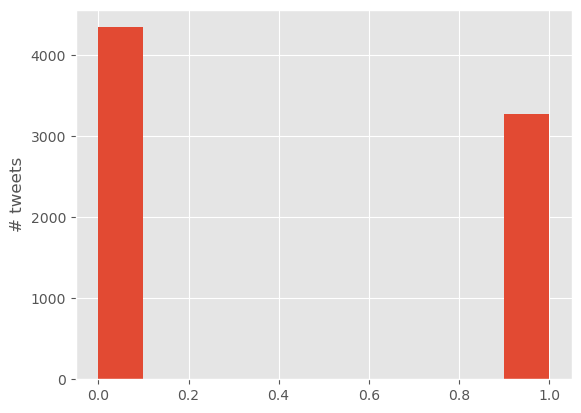

In [26]:
X_train['target'].hist()
plt.ylabel("# tweets")
plt.show()

Siempre conveniente realizar un análisis exploratorio de la distribución de los datos para determinar la mejor manera de resolver el problema

### Número de palabras por Tweet

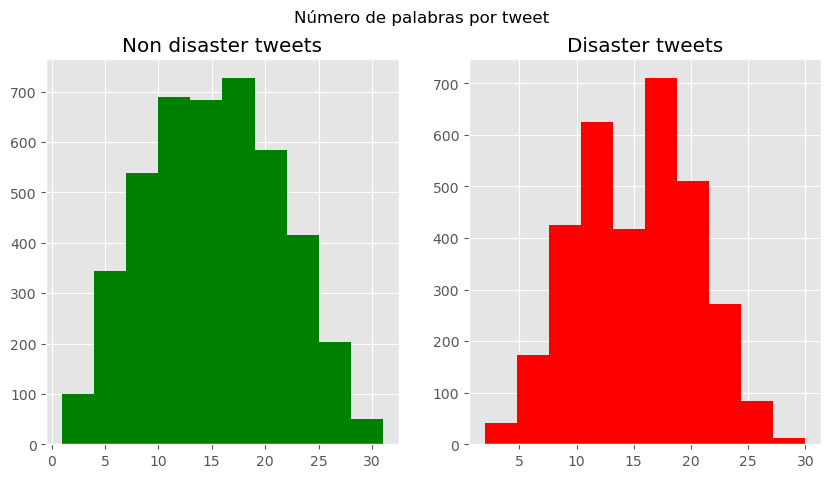

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de palabras
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.split().map(lambda x: len(x))
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.split().map(lambda x: len(x))

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número de palabras por tweet')

plt.show()

### Número de palabras únicas por Tweet

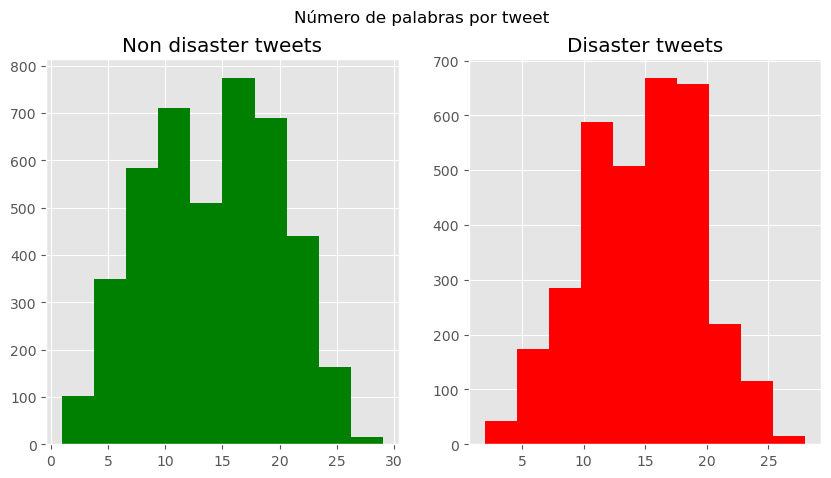

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de palabras
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.split().map(lambda x: len(set(x)))
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.split().map(lambda x: len(set(x)))

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número de palabras por tweet')

plt.show()

### Longitud media de las palabras por Tweet

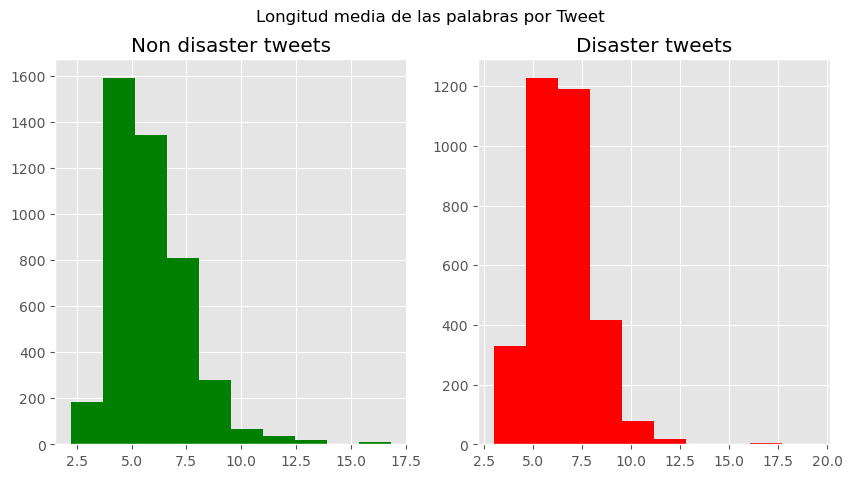

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de palabras
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.split().map(lambda x: np.mean([len(i) for i in x]))
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.split().map(lambda x: np.mean([len(i) for i in x]))

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Longitud media de las palabras por Tweet')

plt.show()

### Número de caracteres por tweet

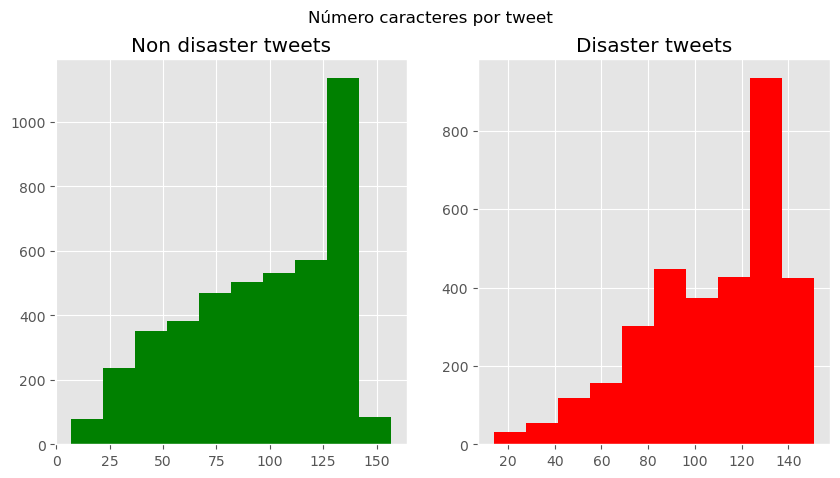

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de caracteres por tweet
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.len()
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.len()

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número caracteres por tweet')

plt.show()

Podríamos seguir calculando características de entrada como las siguientes:
* Número de palabras de fin por Tweet
* Número de urls por Tweet
* Media de caracteres por Tweet
* Número de caracteres por Tweet
* Número de signos de puntuación por Tweet
* Número de hashtags por Tweet
* Número de @ por tweet

### Stopwords más utilizadas

Estas palabras no tienen un significado por si solas, sino que modifican o acompañan a otras, este grupo suele estar conformado por artículos, pronombres, preposiciones, adverbios e incluso algunos verbos.

En el procesamiento de datos en lenguaje natural son filtradas antes o después del proceso en si, no se consideran por su nulo significado, en el caso de los buscadores como Google no lo consideran al momento de posicionar, pero si al momento de mostrar los resultados de búsqueda.

In [35]:
stopwords.words('english')

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/cristianariel/nltk_data'
    - '/Users/cristianariel/miniconda3/nltk_data'
    - '/Users/cristianariel/miniconda3/share/nltk_data'
    - '/Users/cristianariel/miniconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [36]:
def plot_stopwords(label):
    tweets_stopwords = {}
    for words in X_train[X_train['target'] == label]['text'].str.split():
        sw = list(set(words).intersection(stopwords.words('english')))
        for w in sw:
            if w in tweets_stopwords.keys():
                tweets_stopwords[w] += 1
            else:
                tweets_stopwords[w] = 1
                
    top = sorted(tweets_stopwords.items(), key=lambda x:x[1],reverse=True)[:10]
    plt.bar(*zip(*top))
    plt.show()

In [37]:
plot_stopwords(0)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/cristianariel/nltk_data'
    - '/Users/cristianariel/miniconda3/nltk_data'
    - '/Users/cristianariel/miniconda3/share/nltk_data'
    - '/Users/cristianariel/miniconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
plot_stopwords(1)

### Análisis signos de puntuación

In [ ]:
def plot_punctuation(label):
    tweets_stopwords = {}
    for words in X_train[X_train['target'] == label]['text'].str.split():
        sw = list(set(words).intersection(string.punctuation))
        for w in sw:
            if w in tweets_stopwords.keys():
                tweets_stopwords[w] += 1
            else:
                tweets_stopwords[w] = 1
                
    top = sorted(tweets_stopwords.items(), key=lambda x:x[1],reverse=True)[:20]
    plt.figure(figsize=(10, 5))
    plt.bar(*zip(*top))
    plt.show()

In [ ]:
plot_punctuation(0)

In [ ]:
plot_punctuation(1)

### Análisis de Ngramas

In [ ]:
cv = CountVectorizer(ngram_range=(2, 2))
sum_words = cv.fit_transform(X_train['text']).sum(axis=0)

# Calculamos 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

In [ ]:
plt.figure(figsize=(15, 7))
plt.barh(*zip(*words_freq))
plt.show()

## 3. Limpieza del conjunto de datos

In [ ]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [ ]:
remove_url("Esto es una prueba: http://localhost:8888/notebooks/Desktop/Workspace/Deep%20Neural%20Networks%20Course/11.%20Consideraciones%20de%20un%20proyecto%20de%20Deep%20Learning/code/Disaster%20Tweets.ipynb")

In [ ]:
class HTMLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []
        
    def handle_data(self, d):
        self.fed.append(d)
        
    def get_data(self):
        return ''.join(self.fed)

def remove_html(text):
    s = HTMLStripper()
    s.feed(text)
    return s.get_data()

In [ ]:
remove_html('<tr><td align="left"><a href="../../issues/51/16.html#article">Phrack World News</a></td>')

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
remove_emoji("Omg another Earthquake 😔😔")

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
remove_punctuation("hola #que tal")

In [ ]:
# Aplicamos nuestras funciones de limpieza del conjunto de datos
X_train_prep = X_train.copy()

X_train_prep['text'] = X_train['text'].apply(remove_url)
X_train_prep['text'] = X_train['text'].apply(remove_html)
X_train_prep['text'] = X_train['text'].apply(remove_emoji)
X_train_prep['text'] = X_train['text'].apply(remove_punctuation)

In [ ]:
# Aplicamos nuestras funciones de limpieza del conjunto de datos
X_test_prep = X_test.copy()

X_test_prep['text'] = X_test['text'].apply(remove_url)
X_test_prep['text'] = X_test['text'].apply(remove_html)
X_test_prep['text'] = X_test['text'].apply(remove_emoji)
X_test_prep['text'] = X_test['text'].apply(remove_punctuation)

In [ ]:
cv = CountVectorizer(ngram_range=(2, 2))
sum_words = cv.fit_transform(X_train_prep['text']).sum(axis=0)

# Calculamos 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

In [ ]:
plt.figure(figsize=(15, 7))
plt.barh(*zip(*words_freq))
plt.show()

## 4. Vectorización del conjunto de datos

In [ ]:
Y_train = X_train_prep['target']

In [ ]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train_prep['text'])

In [ ]:
X_train = X_train.toarray()

In [ ]:
X_train

In [ ]:
X_test = vectorizer.transform(X_test_prep['text'])
X_test = X_test.toarray()

## 5. División del conjunto de datos

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [ ]:
print("Longitud subcojunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjutno de pruebas: ", len(X_test))

## 6. Construcción del modelo

In [ ]:
model = models.Sequential()

model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision']
)

In [ ]:
history = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=1024,
    validation_data=(X_val, Y_val))

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

## 7. Evaluación del modelo

In [ ]:
Y_pred = model.predict(X_test).round(0)
Y_pred

In [ ]:
for i in range(30):
    print("{} - {}".format(X_test_prep['text'][i], Y_pred[i]))